# Clustering methods applied to TCGA Ovarian Cancer Coexpression Matrix

### Author: Brin Rosenthal  (sbrosenthal@ucsd.edu )
**April 15, 2016**

- We will provide a first look into which clustering methods work best on TCGA coexpression matrices, starting with Ovarian Cancer.
- We will visualize these clustering results.
- Clustering methods tested include:
    - Modularity maximization (Louvain)
    - Affinity propagation
    - DBSCAN 
    - Hierarchical clustering
    
- The Ovarian Cancer TCGA Co-expression matrix may be found here https://ucsd-ccb-data-analysis.s3.amazonaws.com/Brin/ccbb_jupyter_genomics/network_analysis/brin_OV_clustering_TCGA/OV.tsv


# Overview of clustering methods

- **Modularity maximization (Louvain)**
    - Maximizes modularity of graph, where modularity (Q) is a measure of how many edges are found within nodes in a community, compared to how many edges are found between nodes in a community)
    
    $ Q = \frac{1}{2m} \sum_{ij} [A_{ij} - \frac{k_i k_j}{2m}] \delta(c_i,c_j) $
    
    Where $A$ is the network adjacency matrix (weighted or unweighted), $k_i$ is the degree of node $i$, $\delta(c_i,c_j)$ is 1 is $i$ is in the same cluster as $j$, and 0 otherwise, and $m$ is the total number of edges in the network
    
    - Blondel, Vincent D., et al. "Fast unfolding of communities in large networks." Journal of statistical mechanics: theory and experiment 2008.10 (2008): P10008.  
    
    
- **Affinity Propagation**
    - Clusters are identified by passing 'messages among nodes in the network
    - Works best in networks with few loops
    - Frey, Brendan J., and Delbert Dueck. "Clustering by passing messages between data points." Science 315.5814 (2007): 972-976.
<img src="screenshots/affinity_prop_example.png" width="300" height="300">


- ** DBSCAN (Density-based spatial clustering of applications with noise)**
    - Dense observations are clustered together- they define a 'core' set (points which have at least n points within a radius $\epsilon$
    - $O(log(n))$
    - Ester, Martin, et al. "A density-based algorithm for discovering clusters in large spatial databases with noise." Kdd. Vol. 96. No. 34. 1996.
<img src="screenshots/DBSCAN_example.png" width="300" height="300">


- ** Hierarchical Clustering (Agglomerative) **
    - Observations begin in their own cluster, merge with nearby observations in a hierarchical fashion.
    - Often plotted in dendrogram form
    - $O(n^3)$
    - Johnson, Stephen C. "Hierarchical clustering schemes." Psychometrika 32.3 (1967): 241-254.
<img src="screenshots/hierarchical_example.png" width="300" height="300">


## Import some useful packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

% matplotlib inline


## Load the OV Coexpression data as a dataframe

In [4]:
OV_df = pd.read_csv('OV.tsv',sep='\t',names=['var1','var2','corr','p'])
nodes = np.union1d(OV_df.var1,OV_df.var2)

# make a multi-indexed dataframe for filling in the blanks

OV_mult_ind = OV_df.copy(deep=True)
OV_mult_ind.index = [OV_df['var1'],OV_df['var2']]

## Translate the coexpression matrix (an edge list) into a network, using NetworkX 

In [5]:
# make the network
G_OV = nx.Graph()
G_OV.add_nodes_from(nodes)

edge_list_w = zip(list(OV_df['var1']),list(OV_df['var2']),list(np.abs(OV_df['corr'])))  # try using absolute value of correlations

G_OV.add_weighted_edges_from(edge_list_w)
edge_list_total = G_OV.edges(data=True)

## Write some functions to process and visualize the data

In [6]:
# find edges < threshold and corresponding list of nodes
def find_edges_thresh(edge_list_total, edge_thresh=.5,weight_flag = 'on'):
    '''
    find edges with weights less than a given threshold, the corresponding nodes,
    return edges, nodes, and graph constructed from these weighted edges and nodes
    
    '''
    
    if weight_flag == 'on':
        elarge=[(u,v,d) for (u,v,d) in edge_list_total if d['weight'] >edge_thresh]
    #esmall=[(u,v,d) for (u,v,d) in edge_list_total if d['weight'] <=edge_thresh]
        # what are the corresponding nodes?
        nodetemp=[]
        [nodetemp.append(u) for (u,v,d) in elarge]
        [nodetemp.append(v) for (u,v,d) in elarge]
    else:
        # if no weights, only return connecting nodes
        elarge=[(u,v) for (u,v,d) in edge_list_total if d['weight'] >edge_thresh]
        # what are the corresponding nodes?
        nodetemp=[]
        [nodetemp.append(u) for (u,v) in elarge]
        [nodetemp.append(v) for (u,v) in elarge]

    # how many edges in elarge?
    print('there are ' + str(len(elarge)) + ' edges with weight greater than ' + str(edge_thresh))

    nodetemp = pd.Series(nodetemp)
    nodesmall = list(nodetemp.unique())
    print('there are ' + str(len(nodesmall)) + ' corresponding nodes')
    
    # make the graph from nodesmall and elarge
    Gtemp = nx.Graph()
    Gtemp.add_nodes_from(nodesmall)
    Gtemp.add_edges_from(elarge)
    
    return elarge, nodesmall, Gtemp


In [7]:
# function to plot clustered heatmap

def plot_clustered_heatmap(xt, p_rename, node_map_r, figsize = [15,15], cmap = 'bwr', idx_subset = None,
                           plot_xy_labels = False,  save_fig=False,figname='temp_cluster_heatmap'):
    # xt is clustered heatmap
    # p_rename is renamed group partitions (so group ids are ordered and sequential)
    # node_map_r is the map from new node ids back to old node ids
    
    if idx_subset==None:
        # if no idx_subset- plot the entire range
        idx_subset = range(len(xt))
        
    # plot sorted version
    plt.figure(figsize=figsize)
    plt.grid('off')
    plt.imshow(xt,cmap=cmap,vmin=-1,vmax=1)
    plt.xlim(0,len(idx_subset))
    plt.ylim(0,len(idx_subset))

    # set labels if plot_xy_labels = True
    if plot_xy_labels:
        xtlabels = [node_id_map[node_map_r[i]] for i in idx_subset]
        ytlabels = xtlabels
    
        plt.xticks(range(len(idx_subset)),xtlabels,rotation=90,fontsize=4)
        plt.yticks(range(len(idx_subset)),ytlabels,fontsize=4)


    # plot the cluster boundaries with a black box
    group_size_thresh = 5

    pVC = p_rename[0].value_counts()
    VC_map = dict(pVC)  # map new group names to value counts

    row_grp = p_rename[0][idx_subset]
    row_grp.index = range(len(row_grp))
    idx_bdry = list(row_grp[np.diff(row_grp)!=0].index)      
    # plot first bounding box
    idx1 = 0
    idx2 = idx_bdry[0]
    plt.plot([idx1, idx1, idx2, idx2, idx1],[idx1, idx2, idx2, idx1, idx1], 'k-')
    # now plot the rest of the bounding boxes
    for i in range(len(idx_bdry)-1):
        idx1 = idx_bdry[i]+1  # add one to compensate for taking diff
        idx2 = idx_bdry[i+1]+1
        n_in_group = VC_map[row_grp[idx1]]
        if n_in_group>group_size_thresh:  # only plot boxes around large communities

            # plot bounding box
            plt.plot([idx1, idx1, idx2, idx2, idx1],[idx1, idx2, idx2, idx1, idx1], 'k-')
    
    if save_fig:
        plt.savefig(figname,dpi=300)



In [8]:
import community
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

def map_modularity(edge_list_total, OV_df, method='louvain'):
    # compute the modularity of graphs with different edge weight thresholds
    mod_list=[]
    num_edge_list = []
    num_node_list = []

    thresh_list = np.linspace(.8,.95,3)
    for edge_weight in thresh_list:
        elarge,nodesmall,Gtemp = find_edges_thresh(edge_list_total, edge_thresh = edge_weight)
        num_edge_list.append(len(elarge))
        num_node_list.append(len(nodesmall))

        if method == 'louvain':
            part_temp = community.best_partition(Gtemp)
            part_temp = pd.Series(part_temp)
            
            # what is the modularity of the graph?
            mod = community.modularity(dict(part_temp),Gtemp)
            print(mod)
        elif method == 'agglomerative_clustering':
            corr_mat, node_map, node_map_r = create_corr_mat(Gtemp,OV_df,fill_all_empty=False)
            
            # then try AgglomerativeClustering on corr_mat
            AC_mdl_row = AgglomerativeClustering(n_clusters=11,linkage='ward')
            AC_mdl_row.fit_predict(corr_mat)
            AC_mdl_col = AgglomerativeClustering(n_clusters=11,linkage='ward')
            AC_mdl_col.fit_predict(corr_mat.T)

            # sort rows and columns by group
            leaves_row = (pd.DataFrame(AC_mdl_row.labels_))
            idx_row = list(leaves_row.sort(0).index)
            leaves_col = (pd.DataFrame(AC_mdl_col.labels_))
            idx_col = list(leaves_col.sort(0).index)

            AClabels = pd.Series(AC_mdl_row.labels_)
            #print(AClabels.value_counts())

            mod = community.modularity(dict(zip(Gtemp.nodes(),list(AClabels))),Gtemp)
            print(mod)
        elif method == 'DBSCAN':
            corr_mat, node_map, node_map_r = create_corr_mat(Gtemp,OV_df,fill_all_empty=False)
            
            # then try AgglomerativeClustering on corr_mat
            DB_mdl_row = DBSCAN(eps=5,min_samples=5)
            DB_mdl_row.fit_predict(corr_mat)
            DB_mdl_col = DBSCAN(eps=5,min_samples=5)
            DB_mdl_col.fit_predict(corr_mat.T)

            # sort rows and columns by group
            leaves_row = (pd.DataFrame(DB_mdl_row.labels_))
            idx_row = list(leaves_row.sort(0).index)
            leaves_col = (pd.DataFrame(DB_mdl_col.labels_))
            idx_col = list(leaves_col.sort(0).index)

            DBlabels = pd.Series(DB_mdl_row.labels_)
            #print(DBlabels.value_counts())

            mod = community.modularity(dict(zip(Gtemp.nodes(),list(DBlabels))),Gtemp)
            print(mod)
        elif method == 'affinity_propagation':
            corr_mat, node_map, node_map_r = create_corr_mat(Gtemp,OV_df,fill_all_empty=False)
            
            # then try AgglomerativeClustering on corr_mat
            AP_mdl_row = AffinityPropagation()
            AP_mdl_row.fit_predict(corr_mat)
            AP_mdl_col = AffinityPropagation()
            AP_mdl_col.fit_predict(corr_mat.T)

            # sort rows and columns by group
            leaves_row = (pd.DataFrame(AP_mdl_row.labels_))
            idx_row = list(leaves_row.sort(0).index)
            leaves_col = (pd.DataFrame(AP_mdl_col.labels_))
            idx_col = list(leaves_col.sort(0).index)

            APlabels = pd.Series(AP_mdl_row.labels_)
            #print(DBlabels.value_counts())

            mod = community.modularity(dict(zip(Gtemp.nodes(),list(APlabels))),Gtemp)
            print(mod)
            
        mod_list.append(mod)
            
    return mod_list, num_edge_list, num_node_list


        

    
def create_corr_mat(Gtemp, OV_df, fill_all_empty=False):
    numnodes = len(Gtemp.nodes())

    # make a map from node ID to sequential 
    node_map = dict(zip(Gtemp.nodes(),range(numnodes)))
    node_map_r = dict(zip(range(numnodes),Gtemp.nodes()))  # reverse node map
    edges = Gtemp.edges(data=True)

    corr_mat = np.zeros([numnodes,numnodes])

    # nested list comprehension to fill in corr_mat EDIT: for loop is better here because we only have to loop over existing edges
    # corr_mat = [[i+j for j in range(4)] for i in range(2,4)]

    if fill_all_empty==False:
        for e in range(len(edges)):

            # print out progress
            if (e%10000)==0:
                print('completed ' + str(float(e)/len(edges)) + '%')

            n0 = edges[e][0]
            n1 = edges[e][1]
            w = edges[e][2]['weight']
            nMAP0 = node_map[n0]
            nMAP1 = node_map[n1]

            corr_mat[nMAP0,nMAP1] = w
            corr_mat[nMAP1,nMAP0] = w  # make matrix symmetric

    elif fill_all_empty==True:
        # now fill in the rest of the blanks in correlation matrix by looking up in original table
        # loop over all edges instead- faster than looping over nodes_small 2x and looking up in OV_df
        for e in range(len(OV_df)):
            # print out progress
            if (e%100000)==0:
                print('completed ' + str(float(e)/len(OV_df)) + '%')


            n0 = OV_df['var1'][e]
            n1 = OV_df['var2'][e]

            if (n0 in node_map.keys()) and (n1 in node_map.keys()):
                w = OV_df['corr'][e]
                nMAP0 = node_map[n0]
                nMAP1 = node_map[n1]

                corr_mat[nMAP0,nMAP1] = w
                corr_mat[nMAP1,nMAP0] = w  # symmetrize
    
    return corr_mat, node_map, node_map_r
        
    
    

# How does the modularity of the resulting clusters change as we change the edge-weight cutoff of our graphs?

In [118]:
mod_list, num_edge_list, num_node_list = map_modularity(edge_list_total, OV_df, method='affinity_propagation')

there are 16000 edges with weight greater than 0.8
there are 1642 corresponding nodes
completed 0.0%
completed 0.625%
0.045140577471
there are 3704 edges with weight greater than 0.875
there are 597 corresponding nodes
completed 0.0%
0.0773924198169
there are 126 edges with weight greater than 0.95
there are 122 corresponding nodes
completed 0.0%
0.350933870389


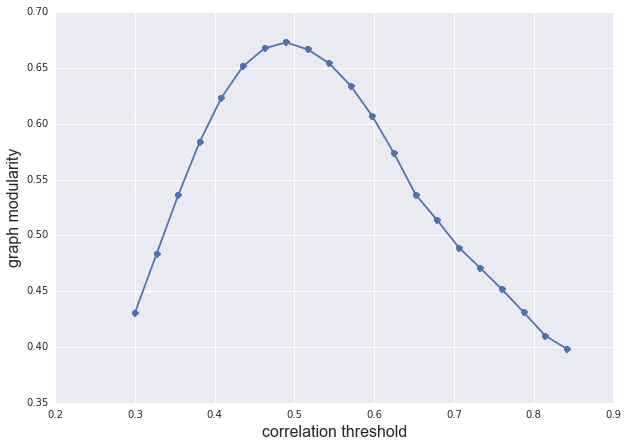

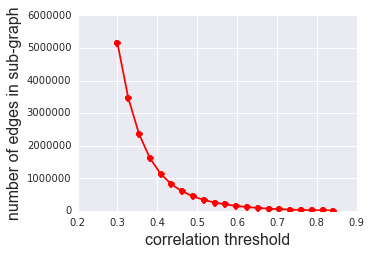

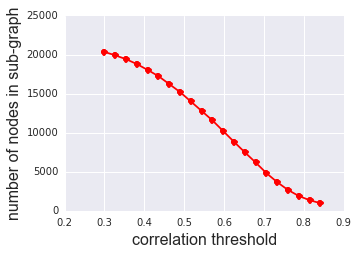

In [1004]:
plt.figure(figsize=(10,7))
# only plot points < .85, because modularity increases artificially after that
plt.plot(thresh_list[0:21],mod_list[0:21],'o-')
plt.xlabel('correlation threshold',fontsize=16)
plt.ylabel('graph modularity',fontsize=16)
plt.savefig('graph_modularity_thresh',dpi=300)  # save figure

plt.figure(figsize=(5,3.5))
plt.plot(thresh_list[0:21],num_edge_list[0:21],'ro-')
plt.xlabel('correlation threshold',fontsize=16)
plt.ylabel('number of edges in sub-graph',fontsize=16)
plt.savefig('num_edges_thresh',dpi=300,bbox_inches='tight',pad_inches=.2)

plt.figure(figsize=(5,3.5))
plt.plot(thresh_list[0:21],num_node_list[0:21],'ro-')
plt.xlabel('correlation threshold',fontsize=16)
plt.ylabel('number of nodes in sub-graph',fontsize=16)
plt.savefig('num_nodes_thresh',dpi=300,bbox_inches='tight',pad_inches=.2)


- ** There is a clear maximum in the modularity graph at correlation threshold ~ 0.48 **
- At this threshold we still retain a majority of the nodes in the graph (15,000/20,000), while also reducing the number of edges to a manageable 500,000, down from 5 million at a correlation threshold of 0.3.

## Now let's examine the clustering results more closely

- First run Louvain modularity maximization clustering on the graph, with correlation threshold of 0.6 for tractability within this notebook

In [32]:
# Louvain clustering
import community

elarge,nodesmall,Gtemp = find_edges_thresh(edge_list_total, edge_thresh = .6)

partition = community.best_partition(Gtemp)
partition = pd.Series(partition)


there are 147261 edges with weight greater than 0.6
there are 10094 corresponding nodes


In [11]:
# add column for partition to OV_df, for writing to file
partition = dict(partition)

numedges = len(OV_df.var1)
node1_group = np.zeros(numedges)-1
node2_group = np.zeros(numedges)-1  # initialize for speed, set non-clustered edges to -1

for i in range(numedges):
    
    # print out some progress
    if (i%50000)==0:
        print(str(i/float(numedges)*100) + '% completed')
    
    key1 = OV_df.var1[i]
    key2 = OV_df.var2[i]
    if key1 in partition.keys():
        node1_group[i] = partition[key1]
    if key2 in partition.keys():
        node2_group[i] = partition[key2]

        
#node1_group = [partition[i] if i in partition.keys() else -1 for i in OV_df.var1]
#node2_group = [partition[i] if i in partition.keys() else -1 for i in OV_df.var2]


0.0% completed
0.971288517175% completed
1.94257703435% completed
2.91386555152% completed
3.8851540687% completed
4.85644258587% completed
5.82773110305% completed
6.79901962022% completed
7.7703081374% completed
8.74159665457% completed
9.71288517175% completed
10.6841736889% completed
11.6554622061% completed
12.6267507233% completed
13.5980392404% completed
14.5693277576% completed
15.5406162748% completed
16.511904792% completed
17.4831933091% completed
18.4544818263% completed
19.4257703435% completed
20.3970588607% completed
21.3683473778% completed
22.339635895% completed
23.3109244122% completed
24.2822129294% completed
25.2535014465% completed
26.2247899637% completed
27.1960784809% completed
28.1673669981% completed
29.1386555152% completed
30.1099440324% completed
31.0812325496% completed
32.0525210668% completed
33.0238095839% completed
33.9950981011% completed
34.9663866183% completed
35.9376751355% completed
36.9089636526% completed
37.8802521698% completed
38.851540687%

In [12]:
OV_df['var1_group']=node1_group
OV_df['var2_group']=node2_group
print(OV_df.head())

           var1          var2    corr             p  var1_group  var2_group
0  120000000001  120000000002  0.9999  0.000000e+00           4           4
1  120000000001  120000000003  0.9998  0.000000e+00           4           4
2  120000000001  120000000004  0.6491  1.557000e-55           4           4
3  120000000001  120000000005  0.3662  8.019000e-16           4         321
4  120000000001  120000000007  0.5457  1.644000e-36           4           4


In [29]:
# save the dataframe if desired
OV_df.to_csv('OV_with_clusters.csv')

# Plot the clusters in network form

- Spring embedded layout for node positions (more strongly connected nodes are positioned closer together)
- Node colors encode cluster membership found from the Louvain modularity maximization algorithm

In [1]:
# plot the network
import matplotlib.colorbar as cb
import seaborn as sns

vmin=None
vmax=None

cmap = 'Paired'

pos = nx.spring_layout(Gtemp,k=.03)

fig,ax=plt.subplots(figsize=(50,40))


# draw small community nodes as white
partition = pd.Series(partition)
par_VC = partition.value_counts()
groupL5 = list(par_VC[par_VC<5].index)
groupG5 = list(par_VC[par_VC>=5].index)



# select out nodes in small communities
nodes_w = []
[nodes_w.extend(list(partition[partition==i].index)) for i in groupL5]

# now select large community nodes
nodes_c = []
[nodes_c.extend(list(partition[partition==i].index)) for i in groupG5]

GL5 = nx.subgraph(Gtemp,nodes_w)
GG5 = nx.subgraph(Gtemp,nodes_c)

# rename partitions for better use of color space
group_map = dict(zip(groupG5,range(len(groupG5))))
par_rename = []
[par_rename.append(group_map[partition[k]]) for k in nodes_c];

cols = par_rename
cols = pd.Series(cols,index=nodes_c)
#cols[nodes_c]=partition[nodes_c]
#cols = list(cols)

nx.draw_networkx_nodes(Gtemp,node_color = 'w',pos=pos,node_size=100,
                         nodelist=GL5.nodes())
nodes_col = nx.draw_networkx_nodes(Gtemp,pos=pos,node_size=100, nodelist = GG5.nodes(),
                                   cmap=cmap, node_color=cols[GG5.nodes()],with_labels=False,alpha=.5,
                                   vmin=vmin,vmax=vmax)
nx.draw_networkx_edges(Gtemp,pos=pos,alpha=0.01,width=2)
plt.grid('off')

# add a colorbar for community IDs
#numcoms = len(groupG5)
#cbar = fig.colorbar(nodes_col,shrink=.5,ticks=[])
#cbar.set_label('Community ID', size=18)



** Run the above code block to generate network figure **
- Static image included here to conserve space

<img src="OV_network_small.jpg" width="500" height="500">

In [49]:
# make an nxn matrix to input to AgglomerativeClustering algo

numnodes = len(Gtemp.nodes()) 
            
corr_mat, node_map, node_map_r = create_corr_mat(Gtemp, OV_df, fill_all_empty=True)





completed 0.0%
completed 0.0194257703435%
completed 0.038851540687%
completed 0.0582773110305%
completed 0.077703081374%
completed 0.0971288517175%
completed 0.116554622061%
completed 0.135980392404%
completed 0.155406162748%
completed 0.174831933091%
completed 0.194257703435%
completed 0.213683473778%
completed 0.233109244122%
completed 0.252535014465%
completed 0.271960784809%
completed 0.291386555152%
completed 0.310812325496%
completed 0.330238095839%
completed 0.349663866183%
completed 0.369089636526%
completed 0.38851540687%
completed 0.407941177213%
completed 0.427366947557%
completed 0.4467927179%
completed 0.466218488244%
completed 0.485644258587%
completed 0.505070028931%
completed 0.524495799274%
completed 0.543921569618%
completed 0.563347339961%
completed 0.582773110305%
completed 0.602198880648%
completed 0.621624650992%
completed 0.641050421335%
completed 0.660476191679%
completed 0.679901962022%
completed 0.699327732366%
completed 0.718753502709%
completed 0.73817927305

In [50]:
# load the id maps
miRNAseq_map = pd.read_csv('ID_map_table/miRNAseq.map.txt',sep='\t',names = ['node_name','node_id'])
rnaSeqV2_map = pd.read_csv('ID_map_table/rnaSeqV2.map.txt',sep='\t',names = ['node_name','node_id'])
rppa_map = pd.read_csv('ID_Map_Table/rppa.map.txt',sep='\t',names=['node_name','node_id'])

id_map = pd.DataFrame()
id_map = id_map.append(miRNAseq_map)
id_map = id_map.append(rnaSeqV2_map)
id_map = id_map.append(rppa_map)

node_id_map = dict(zip(id_map['node_id'],id_map['node_name']))


# This is the unclustered correlation matrix for TCGA Ovarian Cancer

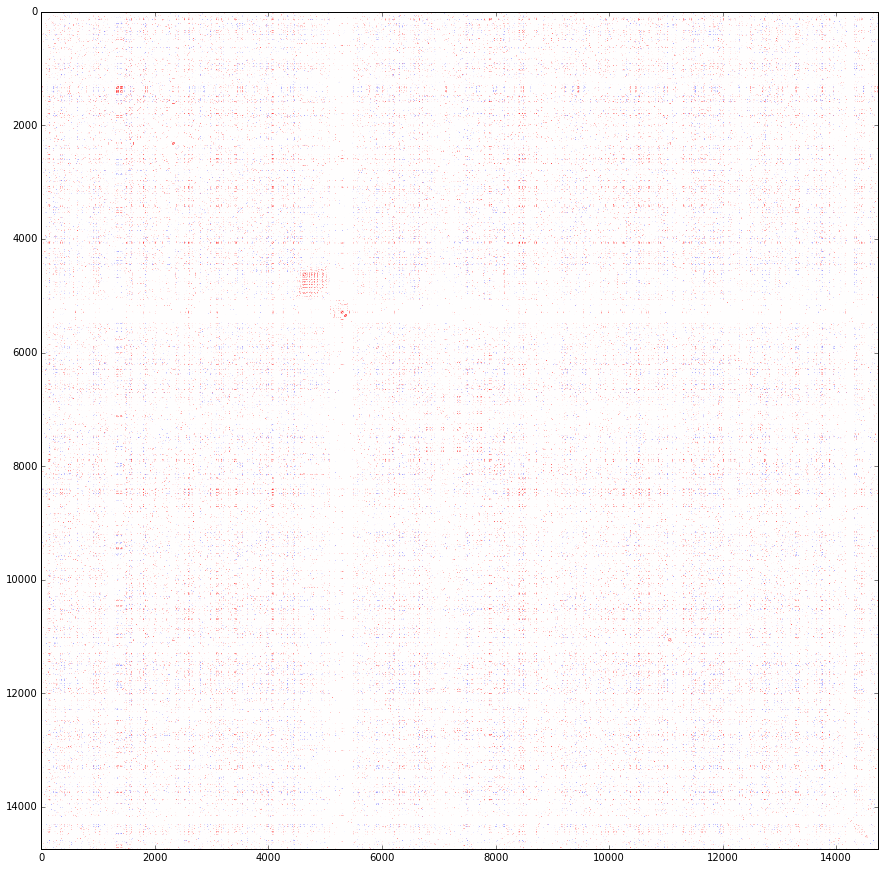

In [115]:
plt.figure(figsize=[15,15])
plt.imshow(corr_mat,cmap='bwr',vmin=-1,vmax=1)

## Now plot the same correlation matrix, with rows and columns ordered by Louvain clustering

- Clear structure here
- Clusters annotate to meaningful GO terms 
    - Cell cycle, q = 9e-88
    - Translation, q = 2e-54
    - Cardio development, q = 2e-61
    - Cilia movmement, q = 2e-23
    - Immune response, q = 2e-198
    
      .



/Users/brin/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:179: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10094 but corresponding boolean dimension is 10093
  return self.values[slicer]
/Users/brin/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1087: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10094 but corresponding boolean dimension is 10093
  result = getitem(key)


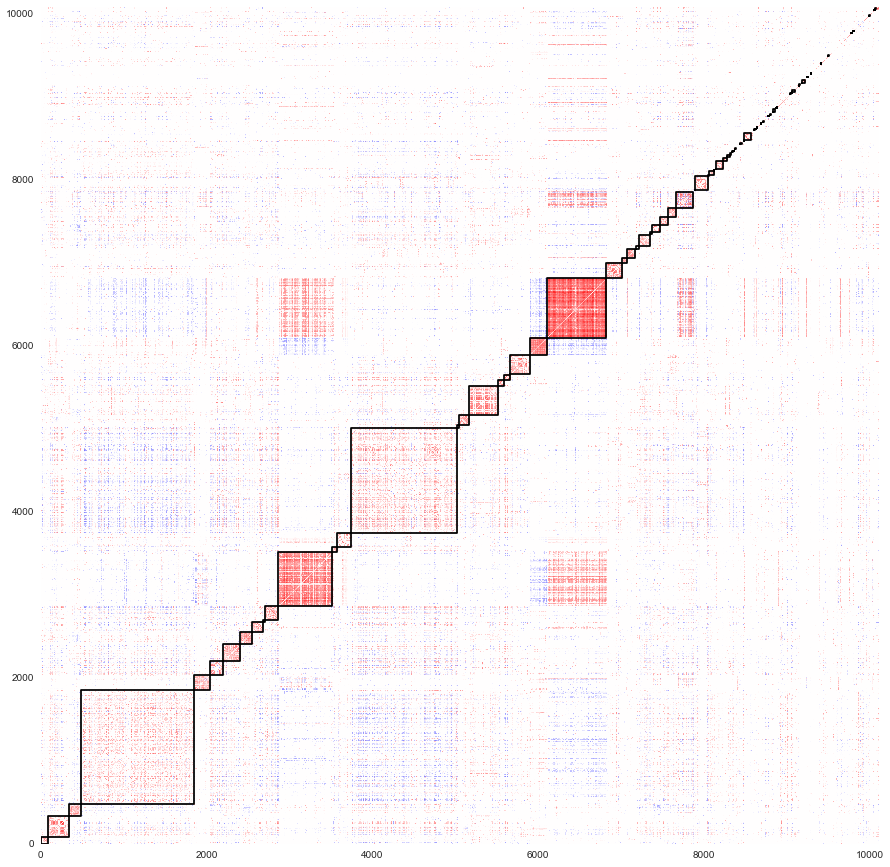

In [52]:
# plot corr_mat grouped by partition communities
p_rename = partition.rename(node_map)
p_rename = pd.DataFrame(p_rename) 
p_rename = p_rename.sort_index()# sort indices so they are ascending
idx_sort = list(p_rename.sort(0).index)
idx_subset = idx_sort #idx_sort[13800:14300] #[11000:13000]
xt = corr_mat
xt = xt[idx_subset,:]
xt = xt[:,idx_subset]

# plot the clustered heatmap
plot_clustered_heatmap(xt, p_rename, node_map_r, figsize = [15,15], cmap = 'bwr', idx_subset = idx_subset,
                           plot_xy_labels = False,  save_fig=False, figname='OV_heatmap_LCD_thresh_5')


## Now try clustering using hierarchical method

(implemented using scikit-learn)

In [66]:
from sklearn.cluster import AgglomerativeClustering
# then try AgglomerativeClustering on corr_mat

AC_mdl_row = AgglomerativeClustering(n_clusters=11,linkage='ward')
AC_mdl_row.fit_predict(corr_mat)
AC_mdl_col = AgglomerativeClustering(n_clusters=11,linkage='ward')
AC_mdl_col.fit_predict(corr_mat.T)

# sort rows and columns by group
leaves_row = (pd.DataFrame(AC_mdl_row.labels_))
idx_row = list(leaves_row.sort(0).index)
leaves_col = (pd.DataFrame(AC_mdl_col.labels_))
idx_col = list(leaves_col.sort(0).index)

AClabels = pd.Series(AC_mdl_row.labels_)
print(AClabels.value_counts())

# what is the modularity of the network?
#node_map_r = dict(zip(range(numnodes),Gtemp.nodes()))

mod = community.modularity(dict(zip(Gtemp.nodes(),list(AClabels))),Gtemp)
print(mod)

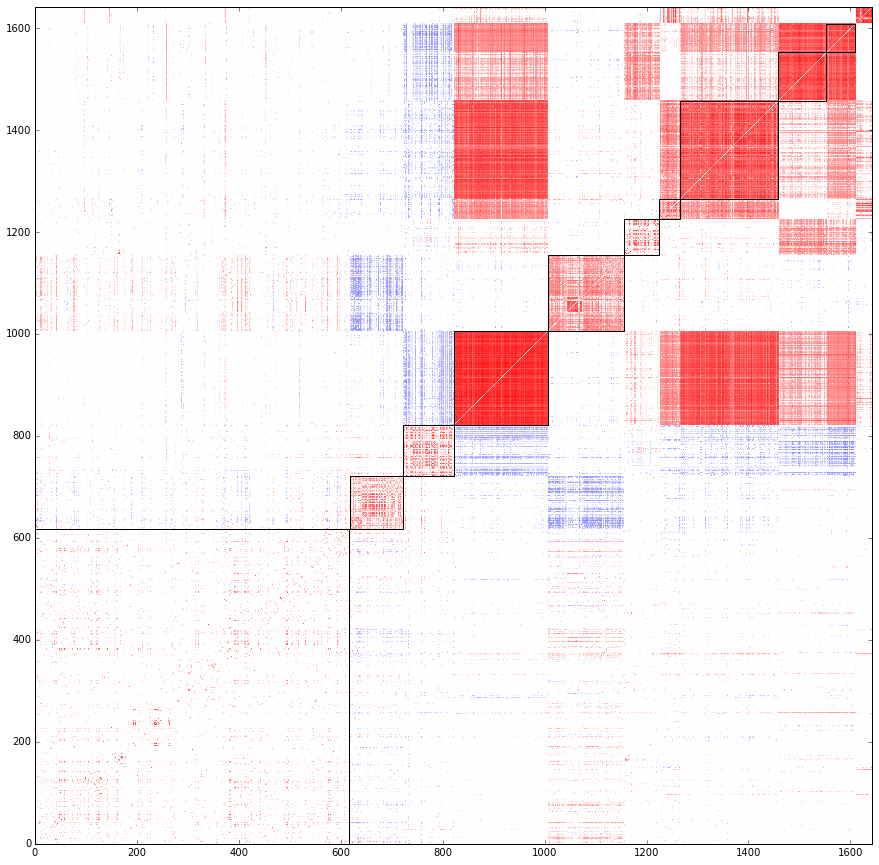

In [68]:
# plot corr_mat grouped by partition communities
AC_rename = pd.DataFrame(AClabels)
idx_sort = list(AC_rename.sort(0).index)
idx_subset = idx_sort #[11000:13000]
xt = corr_mat
xt = xt[idx_subset,:]
xt = xt[:,idx_subset]

# plot the clustered heatmap
plot_clustered_heatmap(xt, AC_rename, node_map_r, figsize = [15,15], cmap = 'bwr', idx_subset = idx_subset,
                           plot_xy_labels = False,  save_fig=False,figname='temp_cluster_heatmap')


** Strong clusters appear, but they are not as cohesive as modularity maximization **

## Cluster using DBSCAN

(Implementation from scikit-learn)

In [21]:
# next try it with DBSCAN
from sklearn.cluster import DBSCAN


DB_mdl_row = DBSCAN(eps=5,min_samples=5)
DB_mdl_row.fit_predict(corr_mat)
DB_mdl_col = DBSCAN(eps=5,min_samples=5)
DB_mdl_col.fit_predict(corr_mat.T)

# sort rows and columns by group
leaves_row = (pd.DataFrame(DB_mdl_row.labels_))
idx_row = list(leaves_row.sort(0).index)
leaves_col = (pd.DataFrame(DB_mdl_col.labels_))
idx_col = list(leaves_col.sort(0).index)

DBlabels = pd.Series(DB_mdl_row.labels_)
print(DBlabels.value_counts())

# what is the modularity of the network?
#node_map_r = dict(zip(range(numnodes),Gtemp.nodes()))

mod = community.modularity(dict(zip(Gtemp.nodes(),list(DBlabels))),Gtemp)
print(mod)

In [22]:
# plot corr_mat grouped by partition communities
DB_rename = pd.DataFrame(DBlabels)
idx_sort = list(DB_rename.sort(0).index)
idx_subset = idx_sort #[11000:13000]
xt = corr_mat
xt = xt[idx_subset,:]
xt = xt[:,idx_subset]

# plot the clustered heatmap
plot_clustered_heatmap(xt, DB_rename, node_map_r, figsize = [15,15], cmap = 'bwr', idx_subset = idx_subset,
                           plot_xy_labels = False,  save_fig=False,figname='temp_cluster_heatmap')

 0    1628
-1      14
dtype: int64
0.000755451874642


- ** DBSCAN does not find clusters effectively in this data **
- We could possibly improve performance by running a parameter scan, but the other methods appear to work better

## Cluster using Affinity Propagation

(implementation from scikit-learn)

In [44]:
# try out affinity propagation
from sklearn.cluster import AffinityPropagation

AP_mdl_row = AffinityPropagation(damping = .9)
AP_mdl_row.fit_predict(corr_mat)
AP_mdl_col = AffinityPropagation(damping = .9)
AP_mdl_col.fit_predict(corr_mat.T)

# sort rows and columns by group
leaves_row = (pd.DataFrame(AP_mdl_row.labels_))
idx_row = list(leaves_row.sort(0).index)
leaves_col = (pd.DataFrame(AP_mdl_col.labels_))
idx_col = list(leaves_col.sort(0).index)

APlabels = pd.Series(AP_mdl_row.labels_)
print(APlabels.value_counts())

# what is the modularity of the network?
#node_map_r = dict(zip(range(numnodes),Gtemp.nodes()))

mod = community.modularity(dict(zip(Gtemp.nodes(),list(APlabels))),Gtemp)
print(mod)

3     525
29     92
25     52
2      51
11     47
33     44
32     43
6      42
18     42
19     41
20     40
22     36
0      36
24     32
1      32
16     30
28     29
4      29
9      26
7      26
15     25
10     24
39     24
14     24
23     22
40     20
31     20
8      19
12     19
37     18
38     18
21     17
13     16
36     15
34     15
35     12
5      12
17     12
27      7
26      5
30      3
dtype: int64
0.210068711772


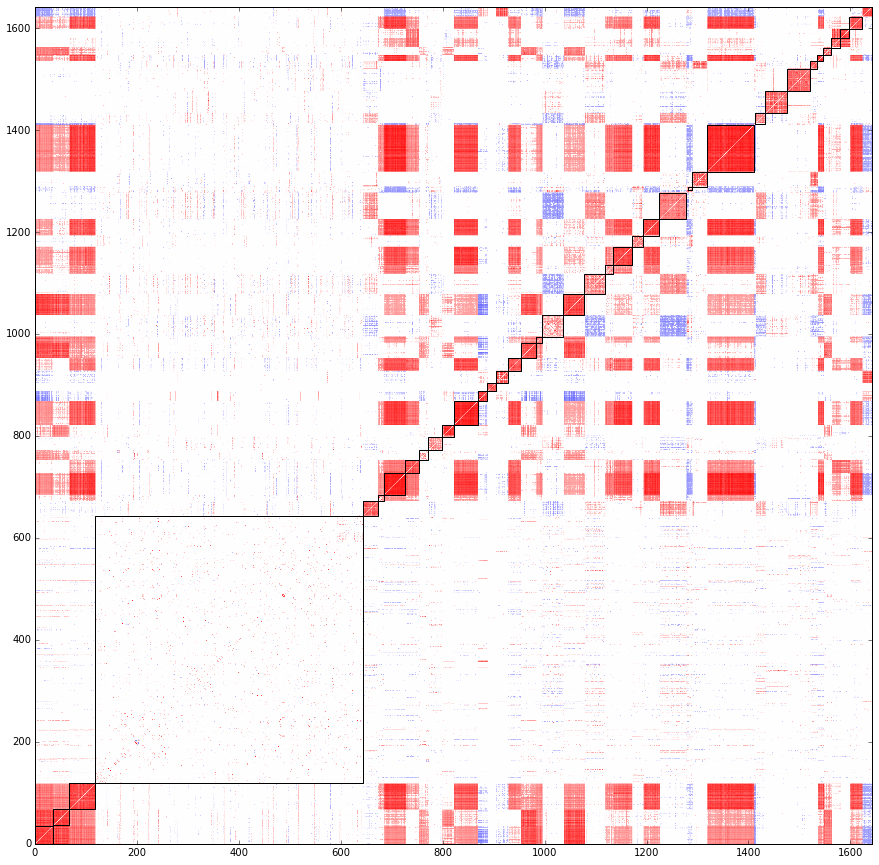

In [45]:
# plot corr_mat grouped by partition communities
AP_rename = pd.DataFrame(APlabels)
idx_sort = list(AP_rename.sort(0).index)
idx_subset = idx_sort #[11000:13000]
xt = corr_mat
xt = xt[idx_subset,:]
xt = xt[:,idx_subset]

# plot the clustered heatmap
plot_clustered_heatmap(xt, AP_rename, node_map_r, figsize = [15,15], cmap = 'bwr', idx_subset = idx_subset,
                           plot_xy_labels = False,  save_fig=False,figname='temp_cluster_heatmap')

** Affinity propagation finds patterns in the data, but does not effectively group clusters together **

## Cluster using Hierarchical Clustering

(implemented using SciPy)


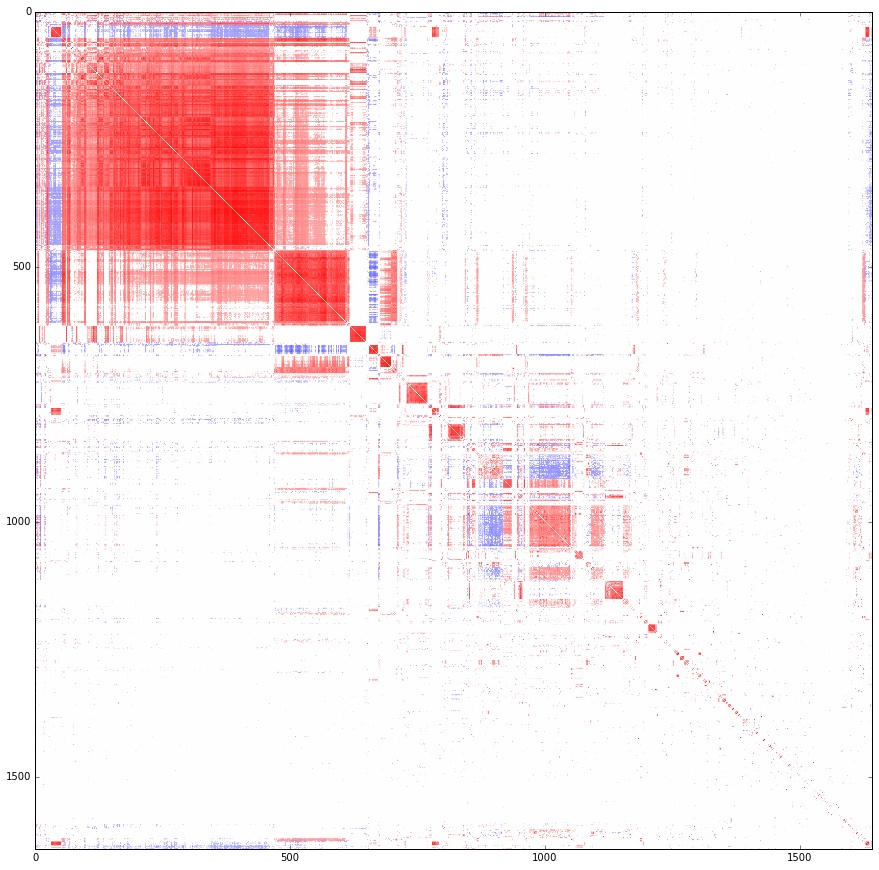

In [65]:
# different implementation of hierarchical clustering:
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch

DRmat = ssd.squareform(ssd.pdist(corr_mat))
DCmat = ssd.squareform(ssd.pdist(np.transpose(corr_mat)))

row_Z = sch.linkage(DRmat)
row_idx = sch.leaves_list(row_Z)

col_Z = sch.linkage(DCmat)
col_idx = sch.leaves_list(col_Z)

plt.figure(figsize = [15,15])
xt = corr_mat
xt = xt[row_idx,:]
xt = xt[:,col_idx]
plt.imshow(xt,cmap='bwr',vmin=-1,vmax=1)
